# Dear LEGO, what happened?!

I used to love playing with LEGO in the 90s when I was growing up, we built many crazy, moving-flying empires with my dad. But now, when I play with my kids, LEGO frustrates me more than anything. Instead of getting creative on building from the infinit stock of the "4er, 8er and some rods and wheels", there are highly specific bits, annoyingly non-matching shades and long users' manuals everwhere in our flat. Is it just me, or has LEGO fundamentally changed the shapes and colors of their bricks? 

To answer this question, I used the data from [rebrickable](https://rebrickable.com/downloads/). This database actually updates daily. The data used in this analysis was downloaded today, on the 3 May 2024. I'm not actually the only one who digged into this data, and I was  inpired by [tidytuesday](https://github.com/rfordatascience/tidytuesday/blob/master/data/2022/2022-09-06/readme.md) for some of the analsis below. 

As always, feedback is very welcome. Enjoy!

# Imports

In [7]:
import csv
import gzip
import os

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # for percentages
import seaborn as sns

%matplotlib inline

In [8]:
# Directory of gzipped files
data_dir = "data/"

# List of gzipped file paths
gz_files = ["colors.csv.gz", "elements.csv.gz", "inventories.csv.gz", "inventory_minifigs.csv.gz", 
            "inventory_parts.csv.gz", "inventory_sets.csv.gz", "part_categories.csv.gz", "part_relationships.csv.gz", 
            "sets.csv.gz", "minifigs.csv.gz", "themes.csv.gz", "parts.csv.gz"]

# Dictionary to store DataFrames
lego_datasets = {}

for file_name in gz_files:
    # construct full file path
    file_path = os.path.join(data_dir, file_name)
    
    data = []

    # Open the gzipped file
    with gzip.open(file_path, "rt") as file:
        reader = csv.reader(file) # CSV header
        columns = next(reader) # for header row
        for row in reader:
           data.append(row)

    # Create a pandas DataFrame
    df_name = file_name.split(".")[0]  # Extract filename without extension
    lego_datasets[df_name] = pd.DataFrame(data, columns = columns)


The datasets are related to each other and contain the following variables: ![](schema_v3.webp)



Let's take a look at the available data first. The smallest element is the parts: we have data on their color composition, themes they belong to, and it can all be arranged to sets, and then inventories. Taking a closer look it turns out that this data covers over 75 years (1949-2025)!

First let's see temporal trends. Is it possible that the reason for the overwhelming complexity of LEGOs is that the sets they published are larger? 

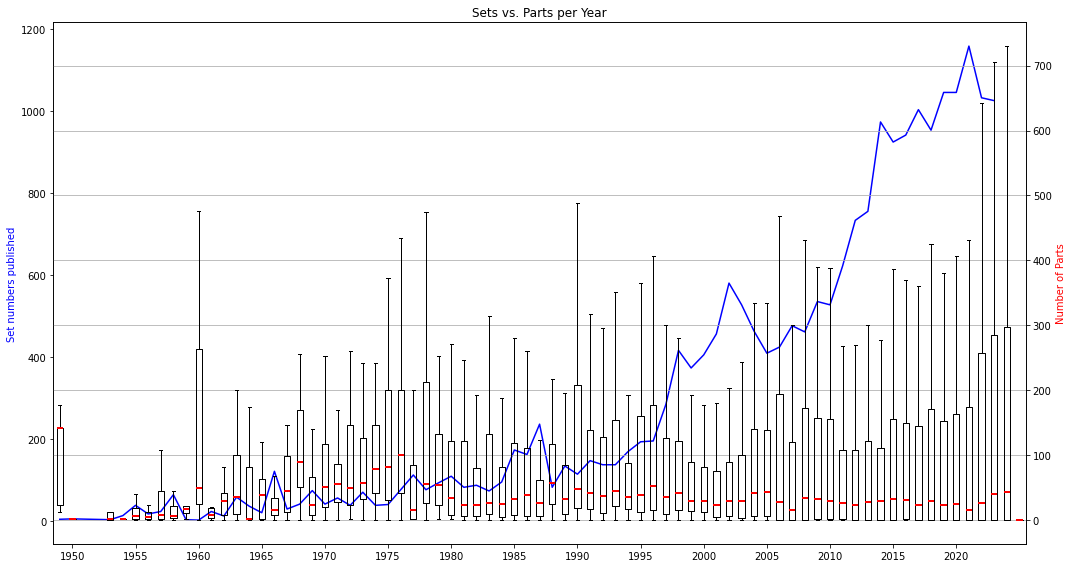

In [9]:

sets = lego_datasets["sets"]

# Set plot
# plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(15, 8), sharex=True)

# Plot 1 - Line plot
sets_num_agg = sets[['year', 'set_num']].groupby(['year']).agg('count')
sets_num_agg.index = sets_num_agg.index.astype(int)
sets_num_agg = sets_num_agg[sets_num_agg.index < 2024] # for completed years only

year = sets_num_agg.index.values
set_number = sets_num_agg['set_num'].values

ax1.plot(year, set_number, color='blue', label='Set numbers published')
ax1.set_ylabel('Set numbers published', color='blue')

# Plot 2 - Boxplot
parts_year = sets[['year', 'num_parts']].astype('int')
parts_year = parts_year[['year', 'num_parts']]

years = np.arange(min(parts_year['year']) + 1, max(parts_year['year']) - 4, 5)

ax2 = ax1.twinx()  # Create a twin axis
bp = ax2.boxplot([group['num_parts'] for year, group in parts_year.groupby('year')],
                 positions=sorted(parts_year['year'].unique()), showfliers=False,
                 medianprops=dict(color='red', linewidth=2))

ax2.set_ylabel('Number of Parts', color='red')  

# Display settings
plt.title('Sets vs. Parts per Year')
plt.xlabel('Year')
plt.xticks(years, years)
plt.grid(True)
plt.gca().set_facecolor('white') 
plt.tight_layout()
plt.show()

Altough there are more sets being published every year, the sets do not increase in size (although the number of parts per set seems to vary more recently than before). Note, that this doesn't tell us about the specificity of parts per set: if a set has set-specific parts, it will increase the overall complexity of "all lego parts in a household". 

## Color composition over time 
I have a feeling there are just too many colors these days in LEGO sets. So I wanted to see what actually happened to the color composition of sets in the past 70+ years. 

This time I'll ignore the sets, and plot the relative occurance of part colors over time. Just like my kids do when they put all their LEGO parts in the middle of our livingroom (maybe they do relative counting? hmm).

By the way, this great idea for visualising shades accross time came from [David Robinson](https://github.com/dgrtwo/data-screencasts/blob/master/2022_09_06_legos.Rmd) at Tidy Tuesday (written in R). 


In [46]:
sets_colors = lego_datasets['sets']\
                .merge(lego_datasets['inventories'], on='set_num', how = 'left')\
                .merge(lego_datasets['inventory_parts'], left_on = 'id', right_on = 'inventory_id', how = 'left')\
                .merge(lego_datasets['colors'], left_on = 'color_id', right_on = 'id', how = 'left')
sets_rgb = sets_colors[['year', 'name_y', 'rgb']].rename(columns = {'name_y':'color'}).set_index('year')
sets_rgb['rgb'] = '#' + sets_rgb['rgb']

# Create a pivot table to count occurrences of each 'rgb' value per 'year'
pivot_table = sets_rgb.pivot_table(index='year', columns='rgb', aggfunc='size', fill_value=0)

# Normalize the counts per yearS
sets_rgb_normalised = pivot_table.div(pivot_table.sum(axis=1), axis=0)


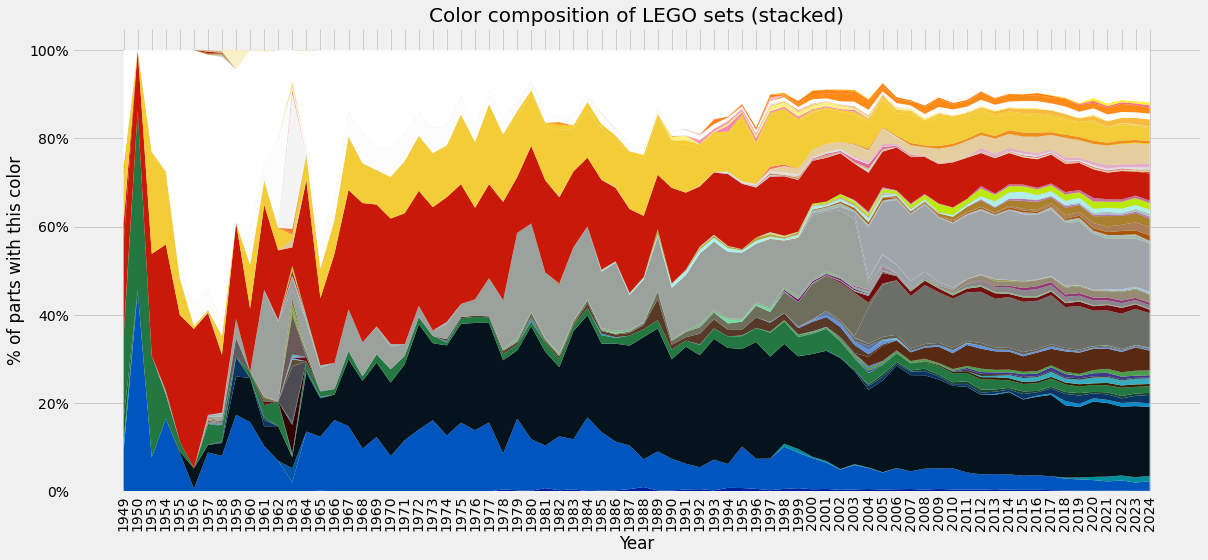

In [48]:
rgb_colors = list(sets_rgb_normalised)

years = sets_rgb_normalised.index
colors = []

for color in rgb_colors:
    colors.append(sets_rgb_normalised[color])
                
plt.figure(figsize=(17, 8))

plt.stackplot(years, colors, 
              colors = rgb_colors)

plt.title('Color composition of LEGO sets (stacked)', fontsize = 20)
plt.xlabel('Year')
plt.ylabel('% of parts with this color')
plt.xticks(rotation = 90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))  # Format y-axis ticks as percentages
plt.tight_layout()
plt.show()


With time more shades of color appear: they started with 5 colors in 1949, and 75 year later there are over 3 dozen shades! This was already a trend in the '80s, but became striking in the 2000s and they didn't stop ever since. Hmm, it does seem like a generational difference after all! 

But there are other noteworthy trends too. 

Interesing to note, that the color red became much less produced over time, and the same is true for blue and for white, although to a lesser extent. Also, there is a big "confusion" in colors in 1963 - this is apparently due to the fact that LEGO [started experimenting](https://www.newelementary.com/2017/01/old-bricks-5-classic-lego-colours.html) with colors. It was also in this year that they started producing the "color" transparent. This color actually accounts for about 30% of their production in that year. It is also interesting to note, that black parts were not really produced before the '60s. Indeed, according to the [official LEGO color timeline](https://www.flickr.com/photos/126975831@N07/15801189140), they only started producing black bricks in 1958, which apparently had technical resons: it was not possible to color the bricks black before given the composition of plastic. Nevertheless, it seems that once LEGO found a stable color trend in the '60s, they pretty much sticked to this composition relative to each other. I also find it interesing to note that they abruptly changed the shade of grey around 2003, so all of a sudden 'retro' and new grey bricks in the same household stopped being visual friends.



## Most common LEGO themes


I was actually wondering if the complexity was due to publishing more sets or that sets within the same theme became well, more complex. To answer this question, I'll plot the most common themes, and then pick one for further evaluation. 

In [26]:
themes = lego_datasets["themes"]

# merge DFs to get parent theme
themes_common = sets.merge(themes, left_on = 'theme_id', right_on = 'id', how = 'left')
themes_common.rename(columns = {'name_y': 'theme_parent', 'name_x': 'theme_child'}, 
                     inplace = True)

# get count data for plot
themes_common_count = themes_common.groupby('theme_parent').size().reset_index(name='count').set_index('theme_parent')

# visualise onyl the top 10% (from 388 themes)
threshold_count = int(len(themes_common_count) * 0.1)
themes_common_count = themes_common_count.sort_values(by = 'count', ascending = False)
themes_common_count_top10 = themes_common_count.head(threshold_count)

# Sort the top 10% themes by theme_count in ascending order
themes_common_count_top10 = themes_common_count_top10.sort_values(by='count', ascending=True)

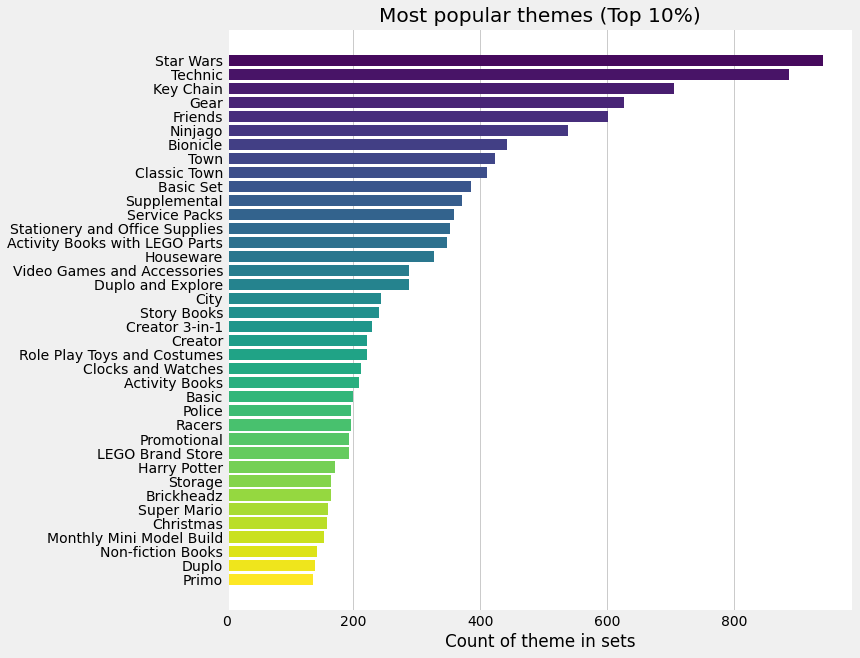

In [27]:
theme_parent = themes_common_count_top10.index.values
count = themes_common_count_top10['count'].values

cmap = mpl.colormaps['viridis_r']

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))

plt.barh(theme_parent, count, color=[cmap(i/len(theme_parent)) for i in range(len(theme_parent))])

plt.gca().set_facecolor('white')
plt.grid(axis = 'y', which = 'major')

plt.title("Most popular themes (Top 10%)")
plt.xlabel("Count of theme in sets")
plt.show()

Oh wow, almost a 1000 Star Wars sets were published since 1949! This is about 8 times more than Harry Potter around the 92th percentile. Partially because well, Harry Potter wasn't even born when Han Solo first kissed the mother of his future twins in the Millenial Falcon... So let's see what happened to Star Wars given that they came out (and trending) with multiple movies accross multiple decades. With some luck this can capture LEGO's intentions regarding the complexity of their sets with the same theme. 